In [1]:
using LombScargle
using Optim
using PyCall
using PyPlot
using Soss
using Statistics
using Stheno
using Stheno: Kernel
using Zygote

In [2]:
# Import the Python package to
# interact with Kepler Archive data
kplr = pyimport("kplr")

# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attach the `kplr` API
client = kplr.API()

# Get the data
star = client.star(KIC_ID)

# Time values
tₐ = Vector{Float64}()

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
fₐ = Vector{Float32}()

# The 1-sigma errors in PDC flux values
fσₐ = Vector{Float32}()

# Get long cadence data of the light curves
for lc in star.get_light_curves(short_cadence = false)

    # Read data from a light curve
    data = lc.read()
    
    t₀ = get(data, "TIME")
    f₀ = get(data, "PDCSAP_FLUX")
    fσ₀ = get(data, "PDCSAP_FLUX_ERR")

    # Create a mask for only qualitative data points
    mask = (get(data, "SAP_QUALITY") .== 0) .& isfinite.(t₀) .& isfinite.(f₀)
    
    append!(tₐ, t₀[mask])
    append!(fₐ, f₀[mask])
    append!(fσₐ, fσ₀[mask])

end

In [3]:
# Get access to rcParams
rcP = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

# Set DPI
rcP["figure.dpi"] = 300

# Activate TeX support
rcP["text.usetex"] = true

# Activate languages support
rcP["text.latex.preamble"] = raw"\usepackage[main=english]{babel}"

# Switch to Computer Modern font set
rcP["mathtext.fontset"] = "cm"

# Set font sizes
rcP["font.size"] = 18
rcP["legend.fontsize"] = 12;

color = "#425378";

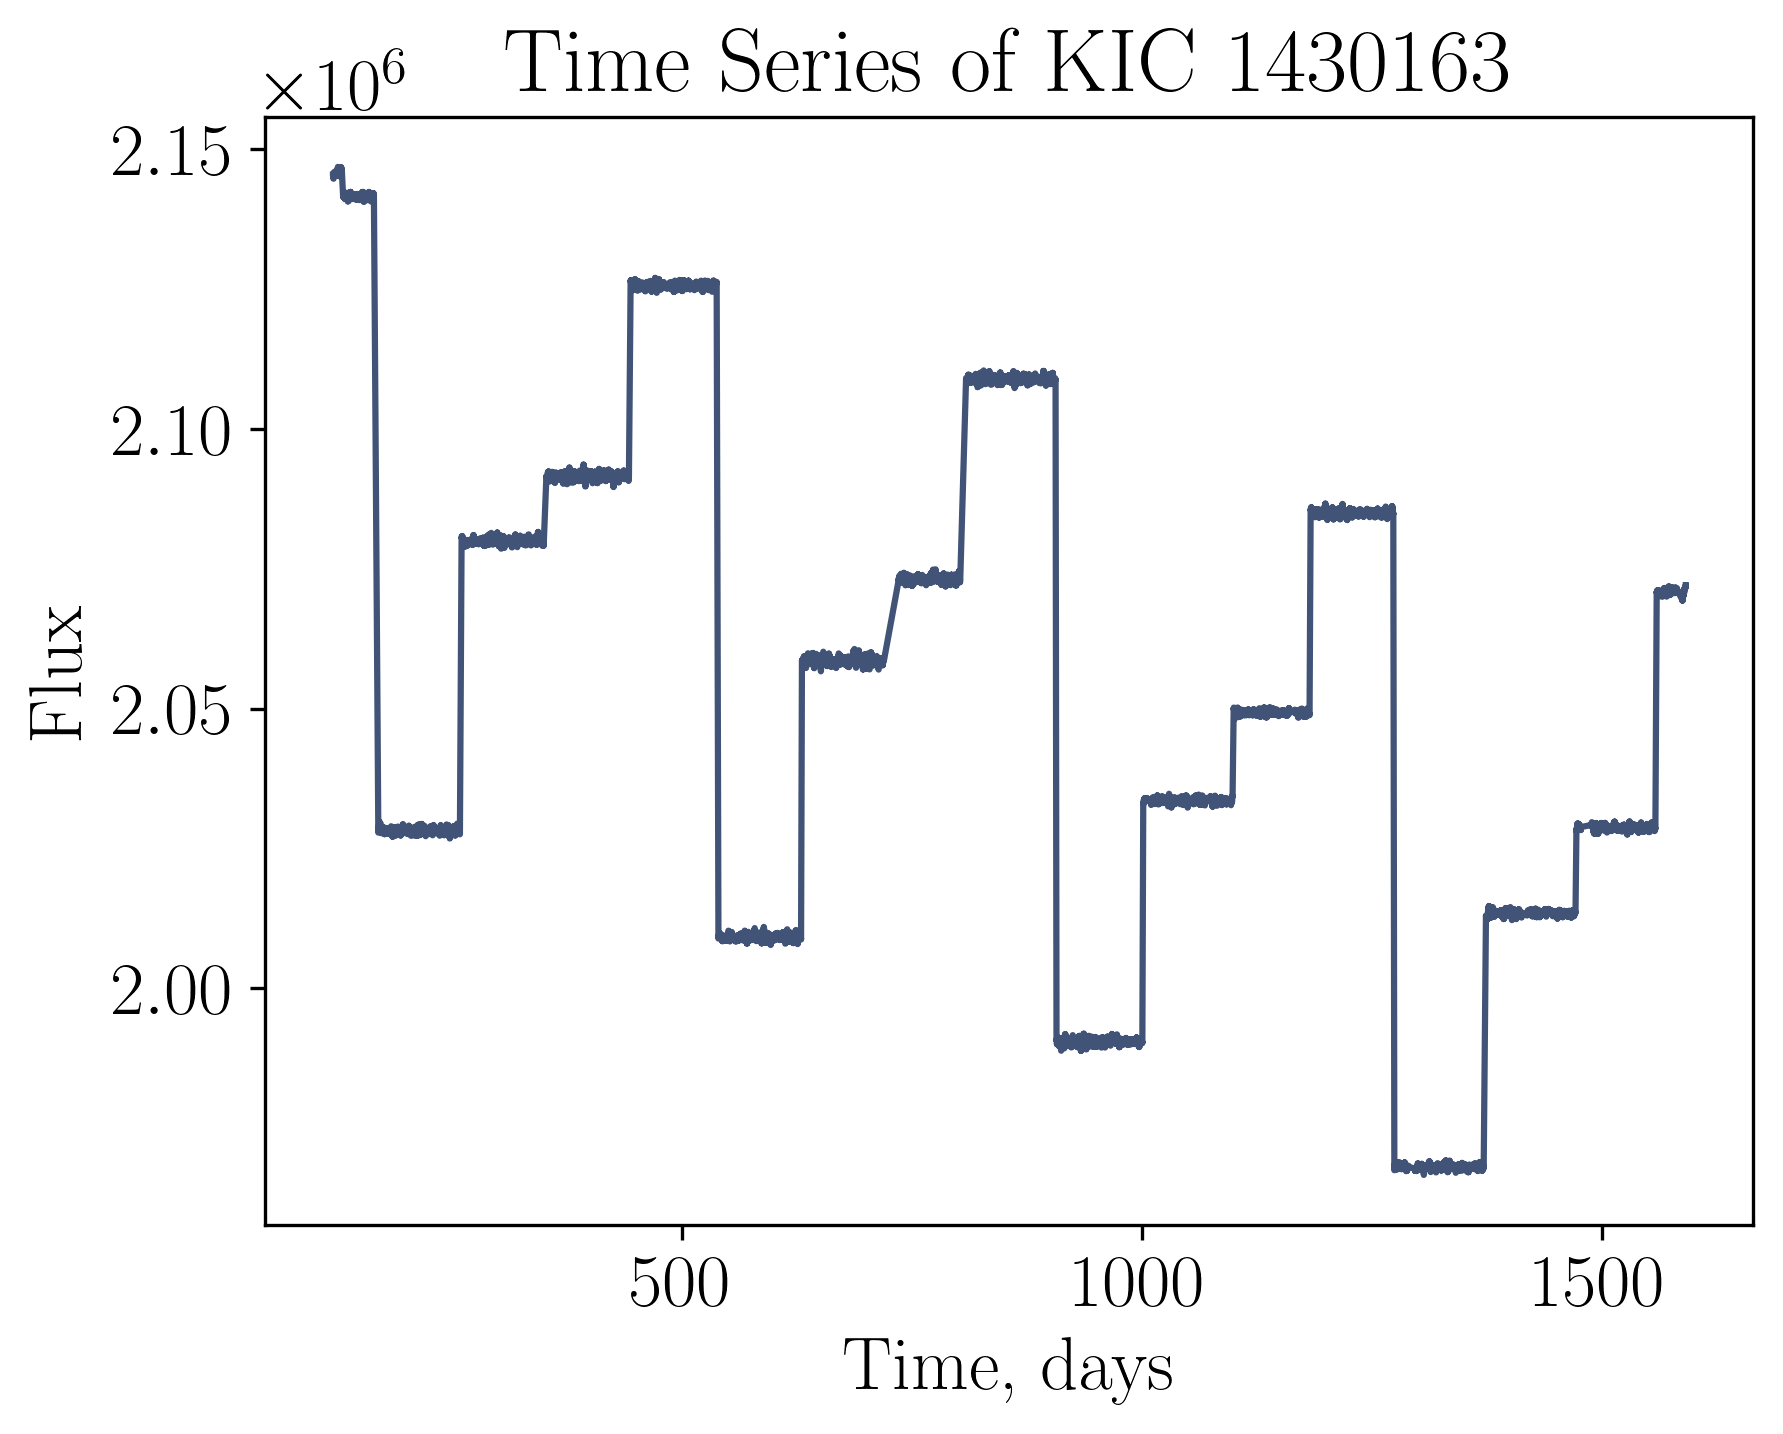

In [4]:
plot(tₐ, fₐ, color)

xlabel(L"\textrm{Time, days}")
ylabel(L"\textrm{Flux}")
title(latexstring("\\textrm{Time Series of KIC $KIC_ID}"));

In [5]:
mask = (tₐ .≥ 443.5105) .& (tₐ .≤ 537.5502295)

tₘ = tₐ[mask]
const t = tₘ .- mean(tₘ)
const f = fₐ[mask]
const fσ = fσₐ[mask]

pad = 30

# Printing the size of the subset
println(rpad("Size of the subset:", pad), size(t, 1))

# Printing the mean of the flux
const μ₀ = mean(f)
println(rpad("Mean of the flux: ", pad), μ₀)
println(rpad("Log of this mean: ", pad), log(μ₀))

# Printing the variance of the subset
const σ²₀ = var(f)
println(rpad("Variance of the subset: ", pad), σ²₀)
println(rpad("Log of this variance: ", pad), log(σ²₀))

# Calculating the mean of the time differences between observations
Δt = []
for i in range(2, size(t, 1), step = 1)
    push!(Δt, t[i] - t[i-1])
end
Δμ = sum(Δt) / size(Δt, 1)
    
# Printing the mean of the time differences
println(rpad("Mean of the time differences:", pad), Δμ)
println(rpad("Log of this mean:", pad), log(Δμ))
println(rpad("1 / Log of this mean:", pad), 1 / log(Δμ))

Size of the subset:           3518
Mean of the flux:             2.125678e6
Log of this mean:             14.569601
Variance of the subset:       209401.3
Log of this variance:         12.2520075
Mean of the time differences: 0.026616617260856176
Log of this mean:             -3.626219549189213
1 / Log of this mean:         -0.2757692926297279


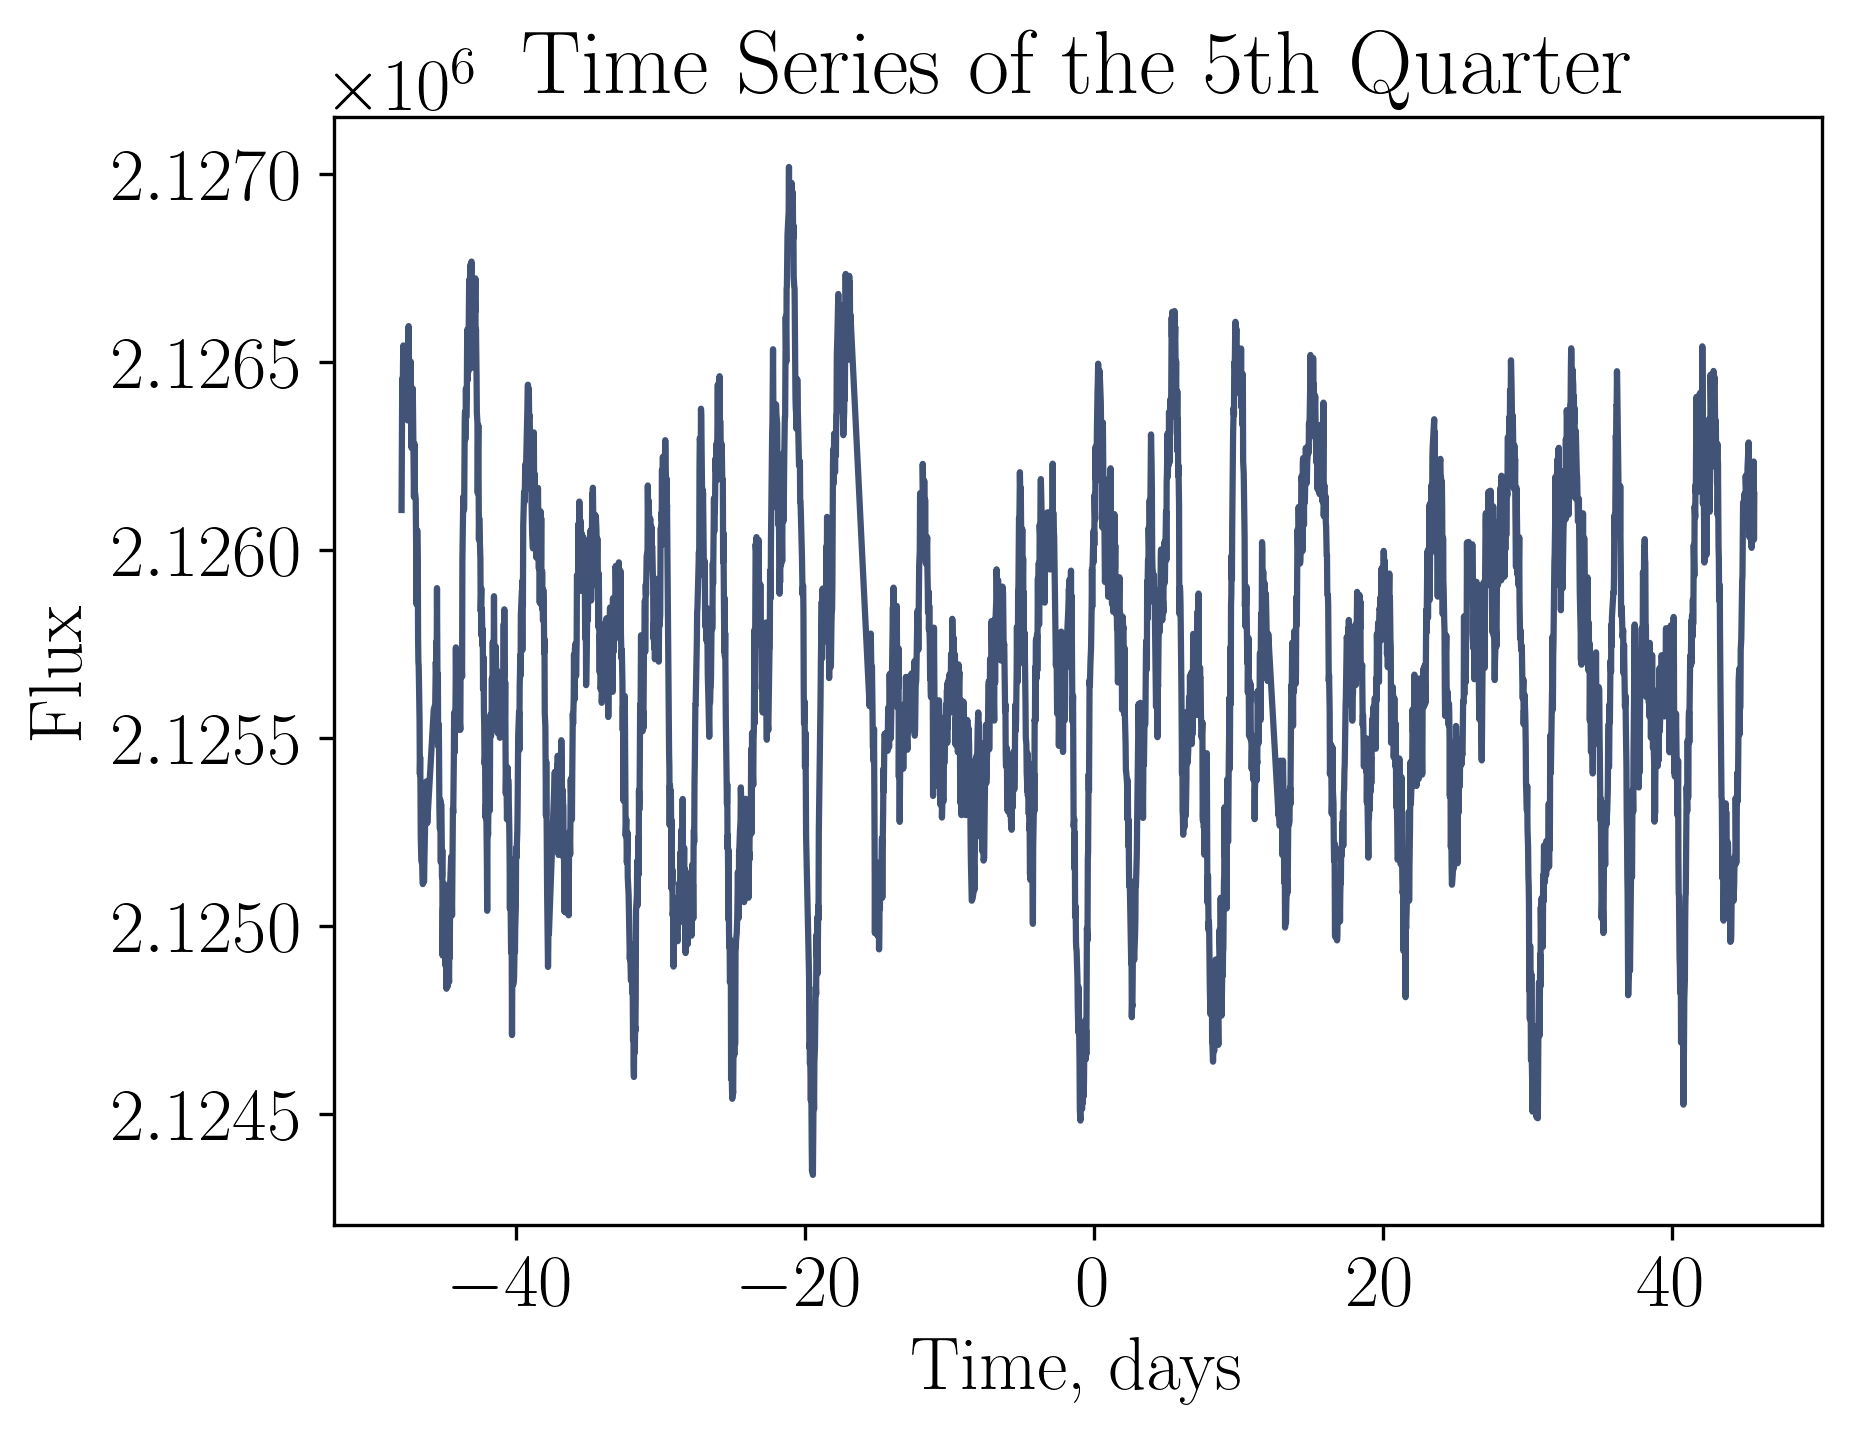

In [6]:
close()
plot(t, f, color)

# Add labels
xlabel(L"\textrm{Time, days}")
ylabel(L"\textrm{Flux}")

# Add a title
title(L"\textrm{Time Series of the 5th Quarter}");

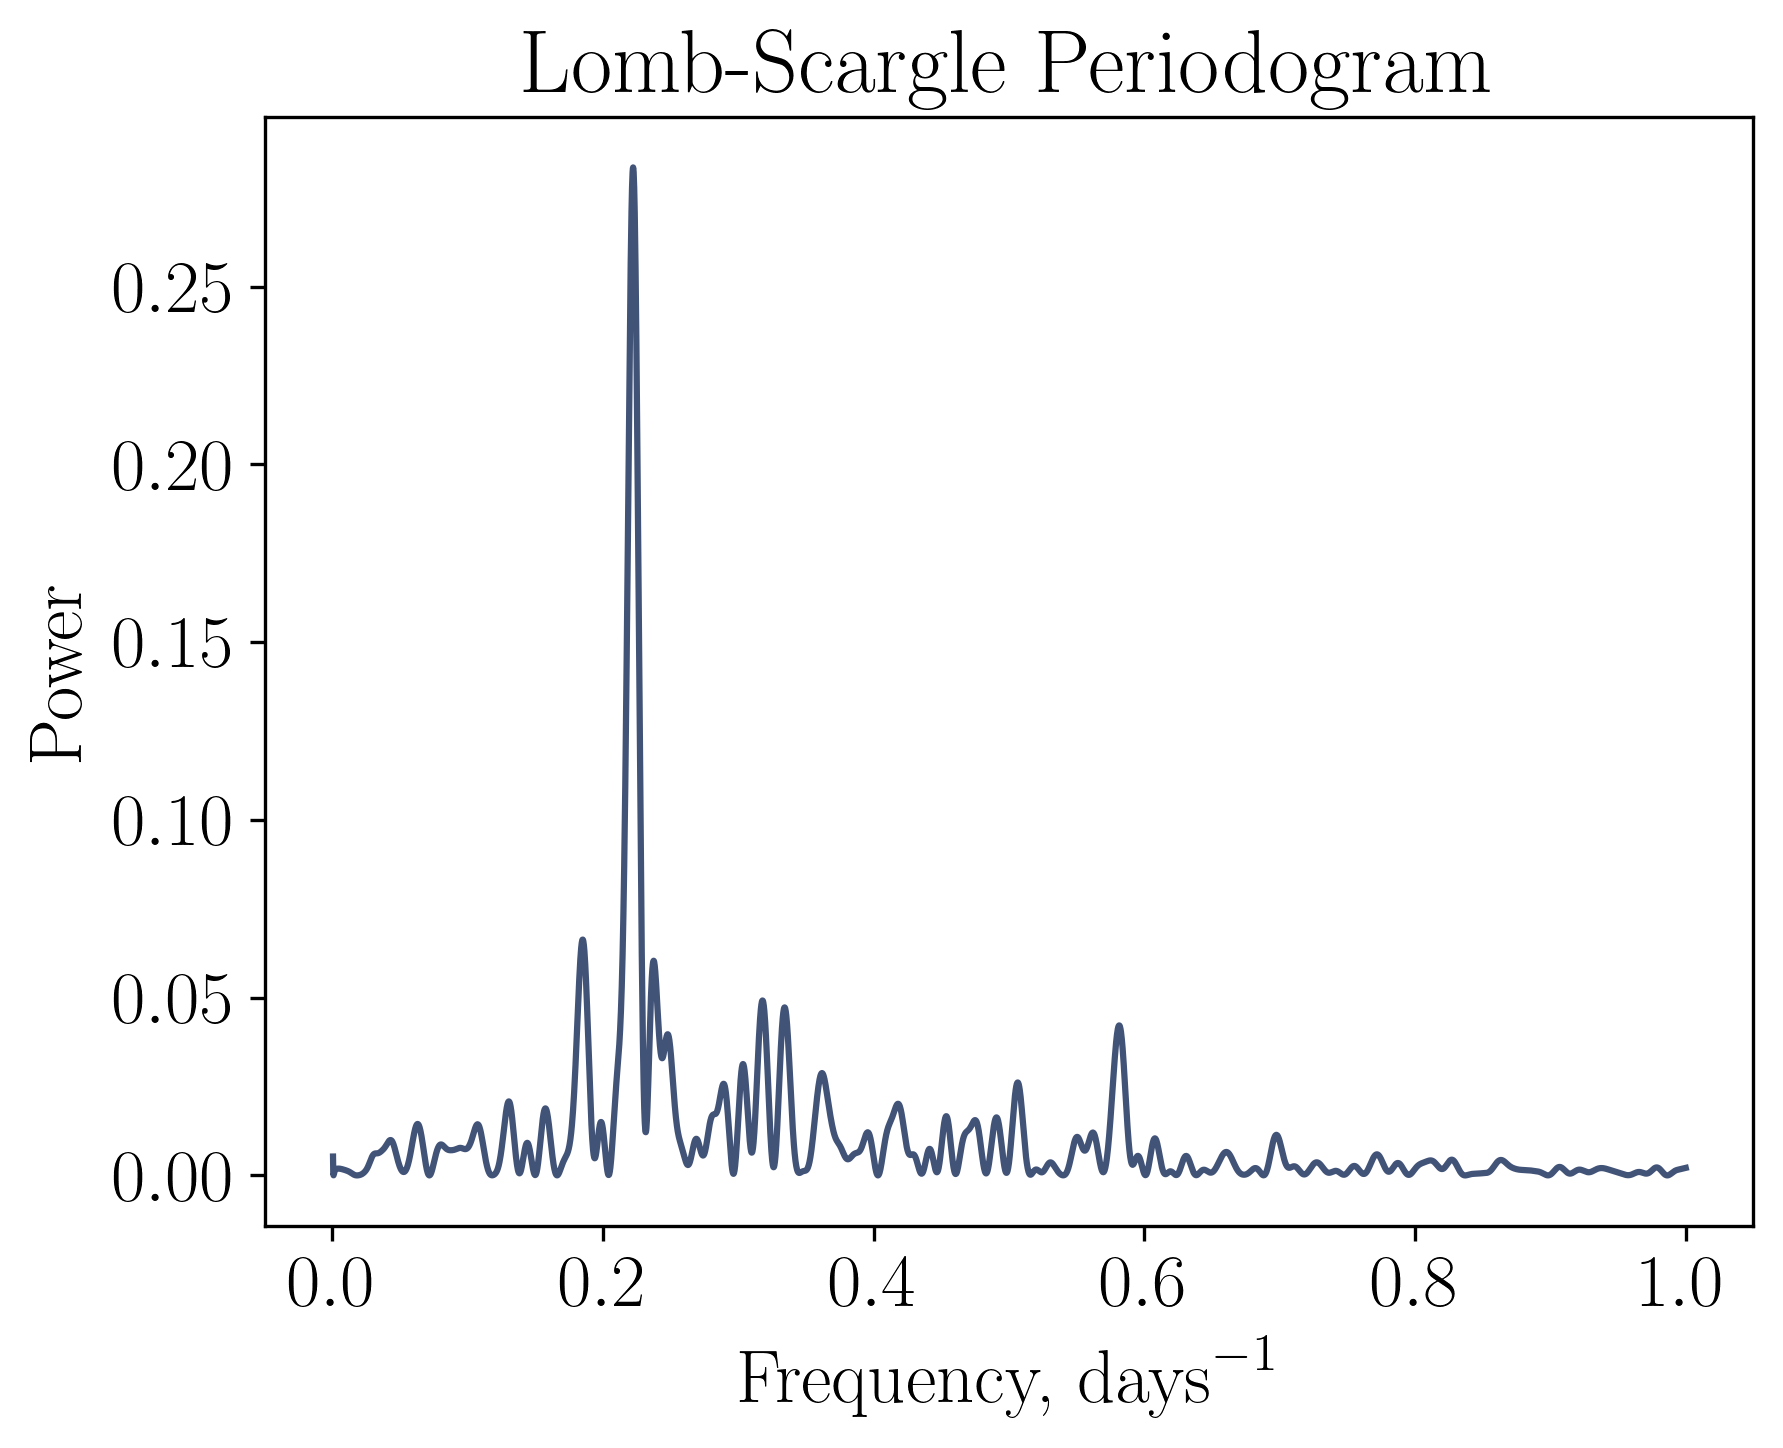

The peak is at 0.2222990081813975.
The relevant estimate of the period is 4.498445621421726.


In [7]:
frequencies = range(1 / size(t, 1) + 0.0003, 1.0; length = 5000)
plan = LombScargle.plan(t, f, fσ; frequencies)

p = lombscargle(plan)
ν, P = freqpower(p)
νₘ = findmaxfreq(p)[1]
P₀ = 1 / νₘ

println("The peak is at $(νₘ).")
println("The relevant estimate of the period is $(P₀).")

close()
plot(ν, P; color)

title(L"\textrm{Lomb-Scargle Periodogram}")
xlabel(L"\textrm{Frequency, days}^{-1}")
ylabel(L"\textrm{Power}");

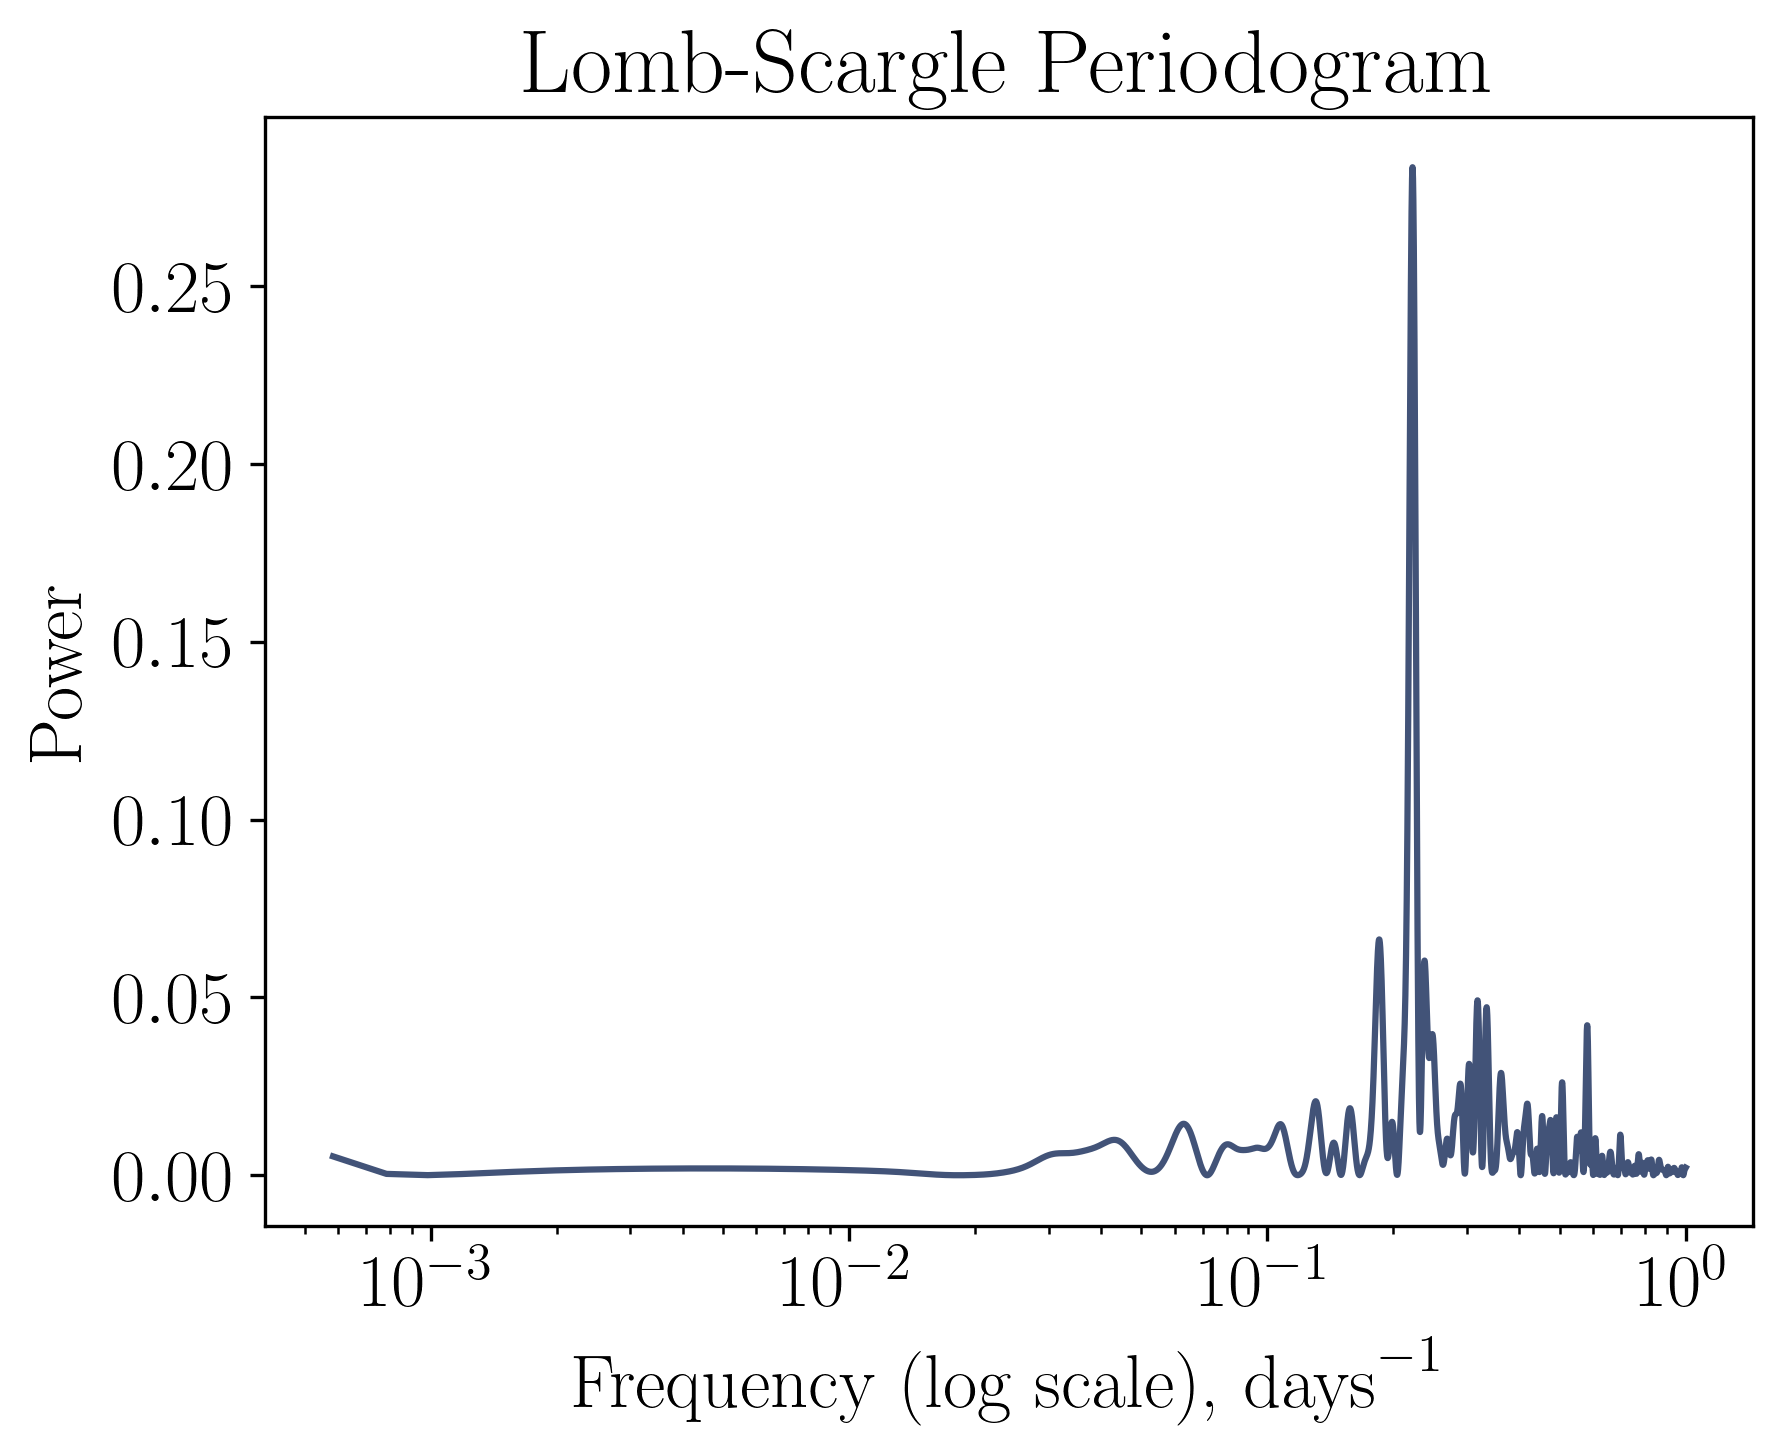

In [8]:
close()
plot(ν, P; color)

title(L"\textrm{Lomb-Scargle Periodogram}")
xlabel(L"\textrm{Frequency (log scale), days}^{-1}")
ylabel(L"\textrm{Power}")
xscale("log")

In [9]:
close()